In [1]:
import matplotlib.pyplot as plt
from pydicom import dcmread
from skimage.transform import rescale, resize, downscale_local_mean
fpath = "C:\\Users\maxim\OneDrive\Documents\master2\WSBIM2243\WSBIM2243\Dataset\\"

Patient ID.......: 
Image size.......: 4084 x 3328


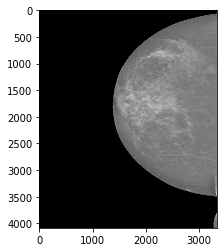

In [2]:
# Test ouverture fichier dicom
path = fpath+ "AllDICOMs\\" + "20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm"
ds = dcmread(path)
pixels = ds.pixel_array

pat_name = ds.PatientName
print(f"Patient ID.......: {ds.PatientID}")
print(f"Image size.......: {ds.Rows} x {ds.Columns}")
"""
display_name = pat_name.family_name + ", " + pat_name.given_name

print(f"Patient's Name...: {display_name}")
print(f"Patient ID.......: {ds.PatientID}")
print(f"Modality.........: {ds.Modality}")
print(f"Study Date.......: {ds.StudyDate}")
print(f"Image size.......: {ds.Rows} x {ds.Columns}")
"""

plt.imshow(pixels, cmap=plt.cm.gray)

In [3]:
from skimage.draw import polygon
import numpy as np
import plistlib

#https://gist.github.com/jendelel/3a8e768a8eb9345d49f2a82d02946122

def load_inbreast_mask(mask_path, imshape=(4084, 3328)):
    """
    This function loads a osirix xml region as a binary numpy array for INBREAST
    dataset
    @mask_path : Path to the xml file
    @imshape : The shape of the image as an array e.g. [4084, 3328]
    return: numpy array where positions in the roi are assigned a value of 1.
    """

    def load_point(point_string):
        x, y = tuple([float(num) for num in point_string.strip('()').split(',')])
        return y, x

    mask = np.zeros(imshape)
    with open(mask_path, 'rb') as mask_file:
        plist_dict = plistlib.load(mask_file, fmt=plistlib.FMT_XML)['Images'][0]
        numRois = plist_dict['NumberOfROIs']
        rois = plist_dict['ROIs']
        assert len(rois) == numRois
        for roi in rois:
            numPoints = roi['NumberOfPoints']
            points = roi['Point_px']
            area = roi['Area']
            center = roi['Center']
            name = roi['Name']
            assert numPoints == len(points)
            
            points = [load_point(point) for point in points]
            if len(points) <= 2:
                for point in points:
                    mask[int(point[0]), int(point[1])] = 1
            else:
                x, y = zip(*points)
                x, y = np.array(x), np.array(y)
                poly_x, poly_y = polygon(x, y, shape=imshape)
                mask[poly_x, poly_y] = 1
    return mask

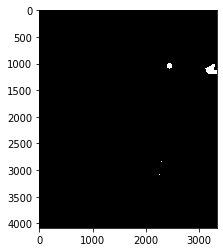

In [4]:
path = fpath+ "AllXML\\" + "20586908.xml"
mask = load_inbreast_mask(path)
plt.imshow(mask, cmap=plt.cm.gray)

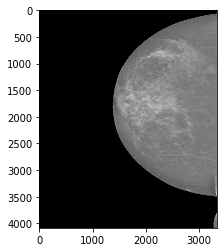

In [7]:
plt.imshow(pixels, cmap=plt.cm.gray)

In [8]:
import csv
# Lecture des descriptions de chaque cas en 1 dictionnaire avec comme clé le numéro du fichier correspondant
l = ["Patient ID","Patient age","Laterality","View;Acquisition date","File Name","ACR","Bi-Rads"]
def create_description(path):
    d = {}
    with open(path, mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        line = 0
        for row in csv_reader:
            value = str(row['Patient ID;Patient age;Laterality;View;Acquisition date;File Name;ACR;Bi-Rads']).split(";")[2:8]
            d[value[3]]=value
    return d
path = fpath + "INbreast.csv"
create_description(path)

{'22678622': ['R', 'CC', '201001', '22678622', '4', '1'],
 '22678646': ['L', 'CC', '201001', '22678646', '4', '3'],
 '22678670': ['R', 'MLO', '201001', '22678670', '4', '1'],
 '22678694': ['L', 'MLO', '201001', '22678694', '4', '3'],
 '22614074': ['R', 'CC', '201001', '22614074', '2', '5'],
 '22614097': ['L', 'CC', '201001', '22614097', '2', '2'],
 '22614127': ['R', 'MLO', '201001', '22614127', '2', '5'],
 '22614150': ['L', 'MLO', '201001', '22614150', '2', '2'],
 '50997434': ['L', 'MLO', '201001', '50997434', '3', '2'],
 '50997461': ['R', 'MLO', '201001', '50997461', '3', '4a'],
 '50997488': ['L', 'CC', '201001', '50997488', '3', '2'],
 '50997515': ['R', 'CC', '201001', '50997515', '3', '4a'],
 '24055445': ['L', 'MLO', '200801', '24055445', '1', '4c'],
 '24055464': ['R', 'MLO', '200801', '24055464', '1', '4c'],
 '24055483': ['L', 'CC', '200801', '24055483', '1', '4c'],
 '24055502': ['R', 'CC', '200801', '24055502', '1', '4c'],
 '22580192': ['R', 'CC', '201001', '22580192', '2', '3'],


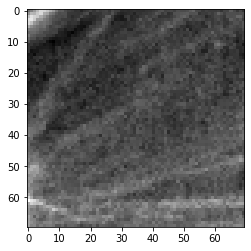

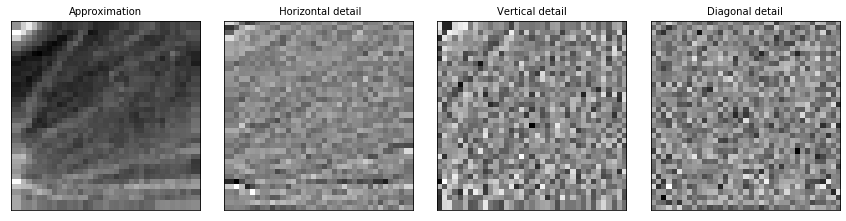

shape of hog features : (576,)
shape of haralick features : (52, 1)


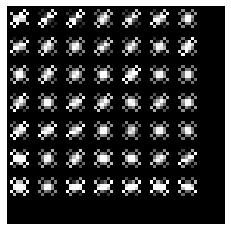

In [17]:
# 2D Wavelet Transform
import pywt
bx = 2110
by = 490
step = 70
crop = pixels[by:by+step,bx:bx+step]
plt.imshow(crop, cmap="gray")
# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(crop, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
LL = LL + abs(min(0,np.amin(LL)))
LH = LH + abs(min(0,np.amin(LH)))
HL = HL + abs(min(0,np.amin(HL)))
HH = HH + abs(min(0,np.amin(HH)))
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()
# HOG (Histogram of Oriented Gradients)
import numpy as np
from skimage.feature import hog
from skimage import data, exposure
import math 
(ly,lx)=crop.shape
fd, hog_image = hog(crop, orientations=4,pixels_per_cell = (math.ceil(ly/8),math.ceil(lx/8)),cells_per_block=(2, 2),visualize=True, multichannel=False)
plt.axis("off")
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
plt.imshow(hog_image_rescaled, cmap="gray")
print("shape of hog features :",fd.shape)

# HOG other implementation
"""
number_bins = 16
((ly,lx))=crop.shape
orientation = np.zeros((ly,lx))
magnitude = np.zeros((ly,lx))
for i in range(ly):
    for j in range(lx):
        if j==0:
            Gx_square = ((crop[i,j+1]-crop[i,j])/1)**2
        elif j==lx-1:
            Gx_square = ((crop[i,j]-crop[i,j-1])/1)**2
        else:
            Gx_square = ((crop[i,j+1]-crop[i,j-1])/2)**2
        
        if i==0:
            Gy_square = ((crop[i+1,j]-crop[i,j])/1)**2
        elif i==ly-1:
            Gy_square = ((crop[i,j]-crop[i-1,j])/1)**2
        else:
            Gy_square = ((crop[i+1,j]-crop[i-1,j])/2)**2
        magnitude[i,j]=np.sqrt(Gx_square+Gy_square)
        orientation[i,j]=np.arctan(Gy_square/Gx_square)
"""        
# Haralick's Textural Features
import mahotas
haralick_LL = mahotas.features.haralick(LL.astype(int)).mean(0)
haralick_LH = mahotas.features.haralick(LH.astype(int)).mean(0)
haralick_HL = mahotas.features.haralick(HL.astype(int)).mean(0)
haralick_HH = mahotas.features.haralick(HH.astype(int)).mean(0)
haralick = np.array([haralick_LL,haralick_LH,haralick_HL,haralick_HH])
haralick = haralick.reshape((-1,1))
print("shape of haralick features :",haralick.shape)
